In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor

In [69]:
train = pd.read_csv("/content/drive/MyDrive/aiffel/Data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/aiffel/Data/test.csv")

In [70]:
data = pd.read_csv("/content/drive/MyDrive/aiffel/Data/train.csv")
sub = pd.read_csv("/content/drive/MyDrive/aiffel/Data/test.csv")
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 22)
sub data dim : (6468, 21)


In [71]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [72]:
sub_id = data['id'][train_len:]

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜(집을 판매한 날짜)
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수(.5는 화장실은 있으나 샤워실은 없는 방)
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도(0~4)
11. condition : 집의 전반적인 상태(1~5)
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
* 1부터13의 지수, 여기서 1,2,3은 건물 구조 및 설계에 미달하고, 7은 평균 수준의 구조 및 설계이며, 11,12,13은 고품질 수준의 구조 및 설계를 나타냅니다.
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 해당 주택을 기준으로 주변 15개 주택의 주거 공간 평균 면적
21. sqft_lot15 : 주변 15개 주택의 부지 면적 평균

*(20,21번 변수는 15년도 시점에서 면적 계산이라는 설명도 있으나, 그렇게 변수를 사용할 시 주거공간이 작아진 데이터가 절반 이상이다.따라서, 위 변수 설명으로 보는게 맞는 것 같다. )


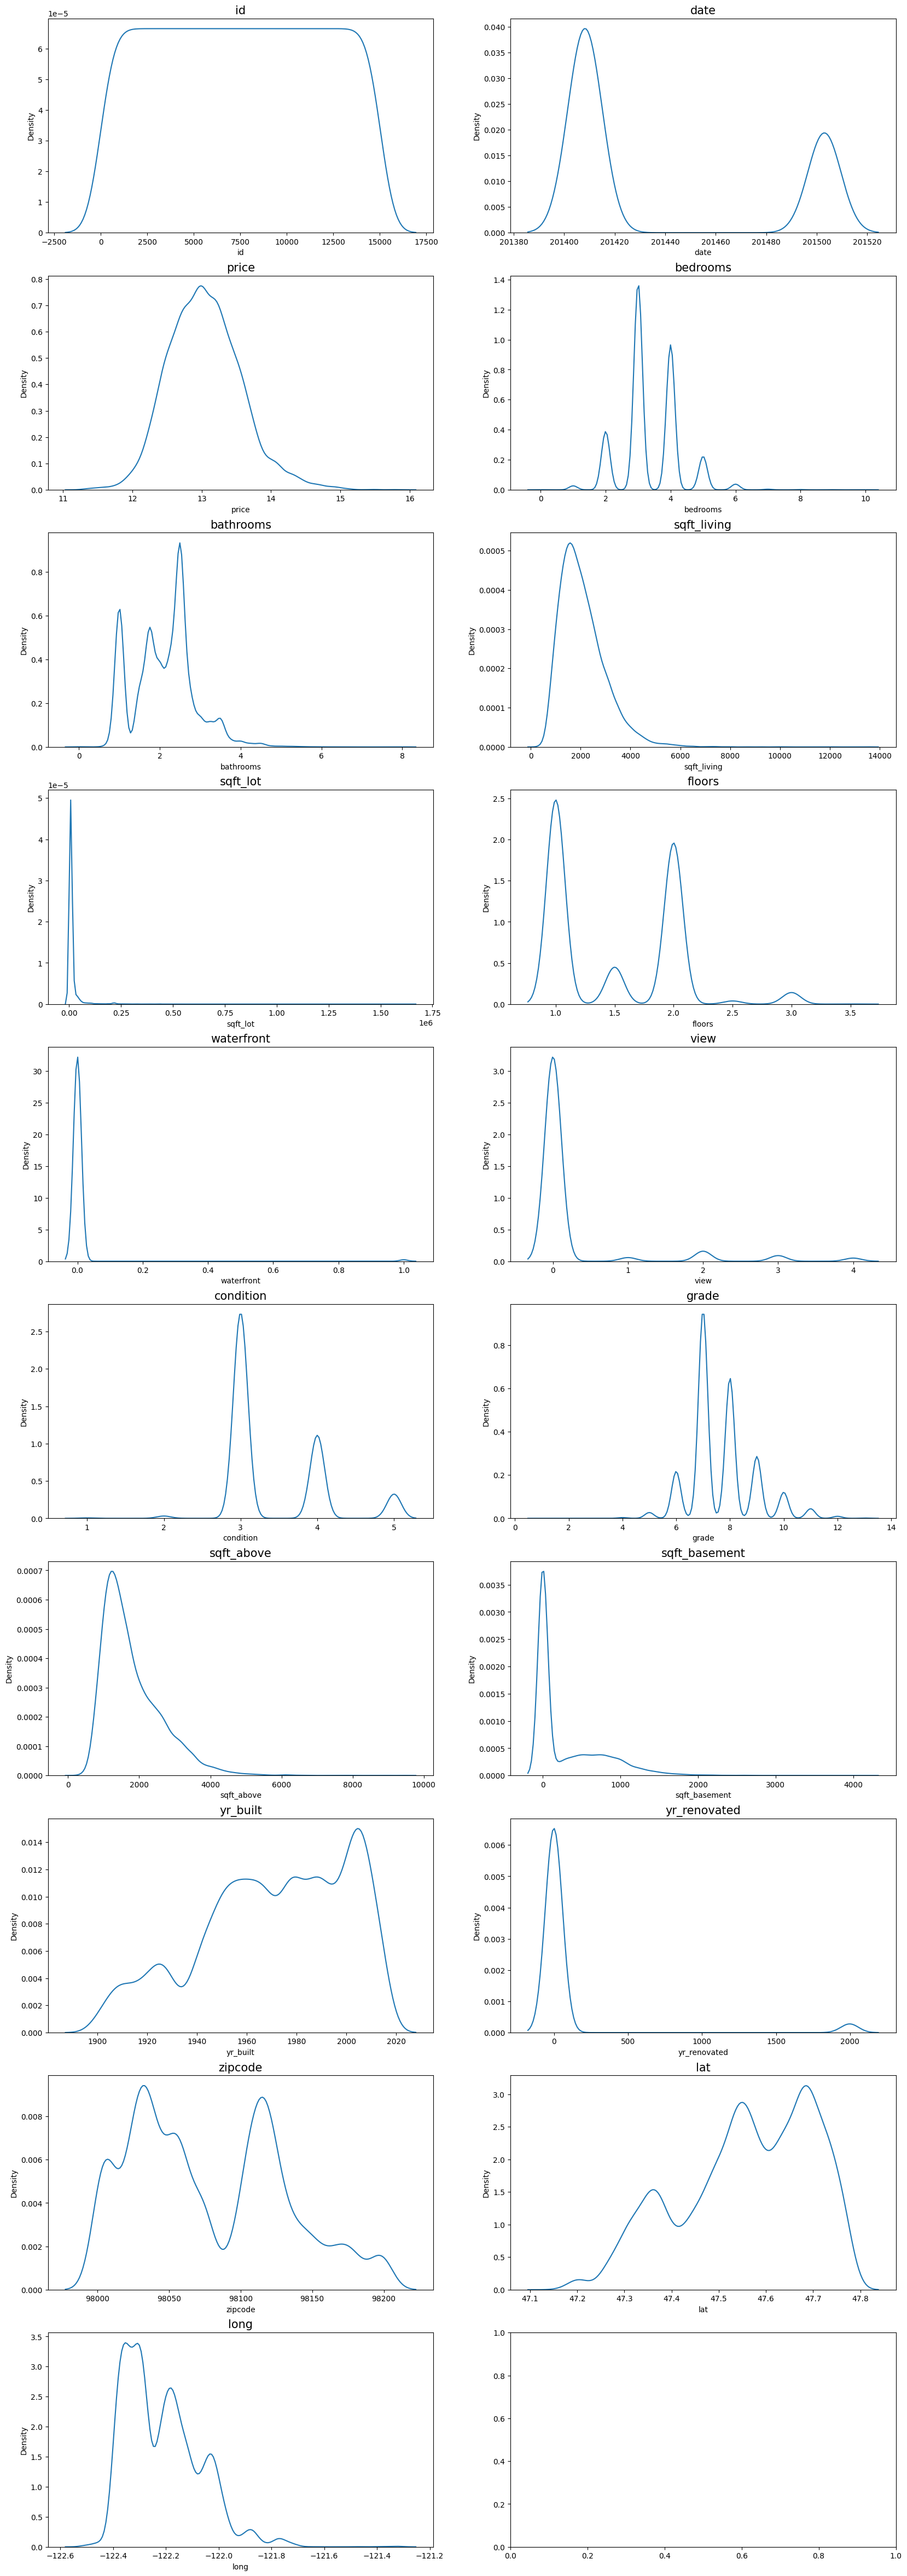

In [6]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# 분포확인
count = 0
columns = train.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

* pgeocode 라이브러리 설치 후, 우편번호로 도시명을 뽑아냈다. 다만, 시간이 오래걸려서 city 변수를 추출, 파일 저장 후, 다시 train,test를 불러왔다.
* 때문에 `train['price]`는 이미 로그 변환이 되어있는 상태.

In [ ]:
# pip install pgeocode

# import pgeocode

# # 미국 우편번호 정보 사용
# nomi = pgeocode.Nominatim('us')

# # 우편번호를 기반으로 도시 이름 가져오기
# def get_city_from_zip(zip_code):
#     location = nomi.query_postal_code(zip_code)
#     return location.place_name if location is not None else None

# # 'city' 열을 추가하여 각 zipcode에 해당하는 도시 이름 저장
# train['city'] = train['zipcode'].apply(get_city_from_zip)

# # 결과 확인
# print(train[['zipcode', 'city']].head())


# # 'city' 열을 추가하여 각 zipcode에 해당하는 도시 이름 저장
# test['city'] = test['zipcode'].apply(get_city_from_zip)

# # 결과 확인
# print(test[['zipcode', 'city']].head())

In [76]:
train['price']

,price
0,12.309987
1,12.100718
2,13.142168
3,12.458779
4,12.583999
...,...
15030,13.322338
15031,13.822984
15032,12.793862
15033,12.899222


In [73]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for i in skew_columns:
    train[i] = np.log1p(train[i].values)

for i in skew_columns:
    test[i] = np.log1p(test[i].values)

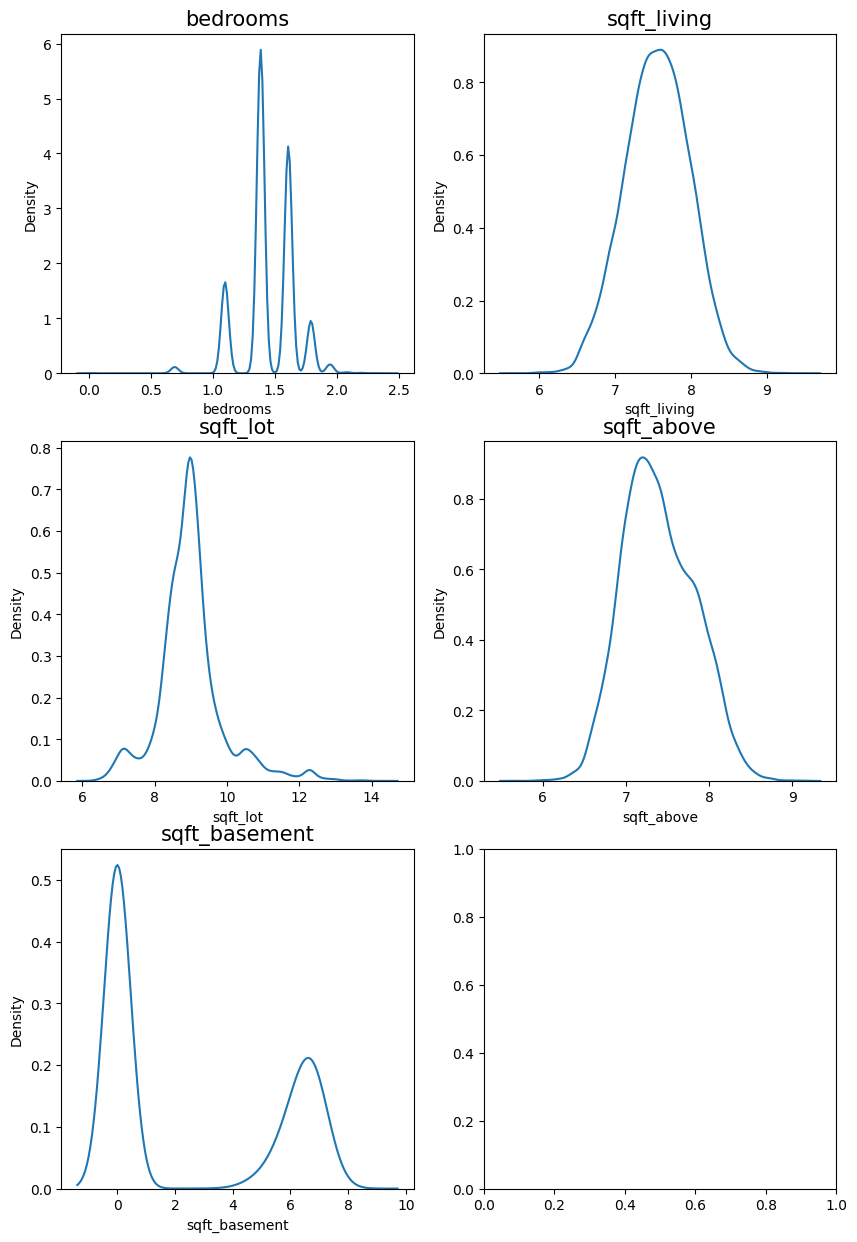

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

In [74]:
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

In [9]:
## date는 큰 의미없다.

# train['date'] = train['date'].astype('int64')
# train['date'] = pd.to_datetime(train['date'], format='%Y%m')
# train['year'] = train['date'].dt.year
# train['month'] = train['date'].dt.month
# train = train.drop(columns=['date'])
# test['date'] = test['date'].astype('int64')
# test['date'] = pd.to_datetime(test['date'], format='%Y%m')
# test['year'] = test['date'].dt.year
# test['month'] = test['date'].dt.month
# test = test.drop(columns=['date'])

In [75]:
## 격자 생성 밀도 뽑아내기

lat_bins = np.linspace(train['lat'].min(), train['lat'].max(), num=100)
long_bins = np.linspace(train['long'].min(), train['long'].max(), num=100)

train['lat_bin'] = np.digitize(train['lat'], bins=lat_bins)
train['long_bin'] = np.digitize(train['long'], bins=long_bins)
test['lat_bin'] = np.digitize(test['lat'], bins=lat_bins)
test['long_bin'] = np.digitize(test['long'], bins=long_bins)

train_density_counts = train.groupby(['lat_bin', 'long_bin']).size().reset_index(name='density')

test_density_counts = test.groupby(['lat_bin', 'long_bin']).size().reset_index(name='density')

# 원본 데이터와 밀도 값을 매칭
train = train.merge(train_density_counts, on=['lat_bin', 'long_bin'], how='left')
test = test.merge(test_density_counts, on=['lat_bin', 'long_bin'], how='left')

# 필요 없는 열 삭제
train.drop(['lat_bin', 'long_bin'], axis=1, inplace=True)
test.drop(['lat_bin', 'long_bin'], axis=1, inplace=True)

# 결과 확인
train[['lat', 'long', 'density']].head()

,lat,long,density
0,47.5112,-122.257,13
1,47.7379,-122.233,12
2,47.6168,-122.045,15
3,47.3097,-122.327,5
4,47.4095,-122.315,4


### 부촌 특정하기

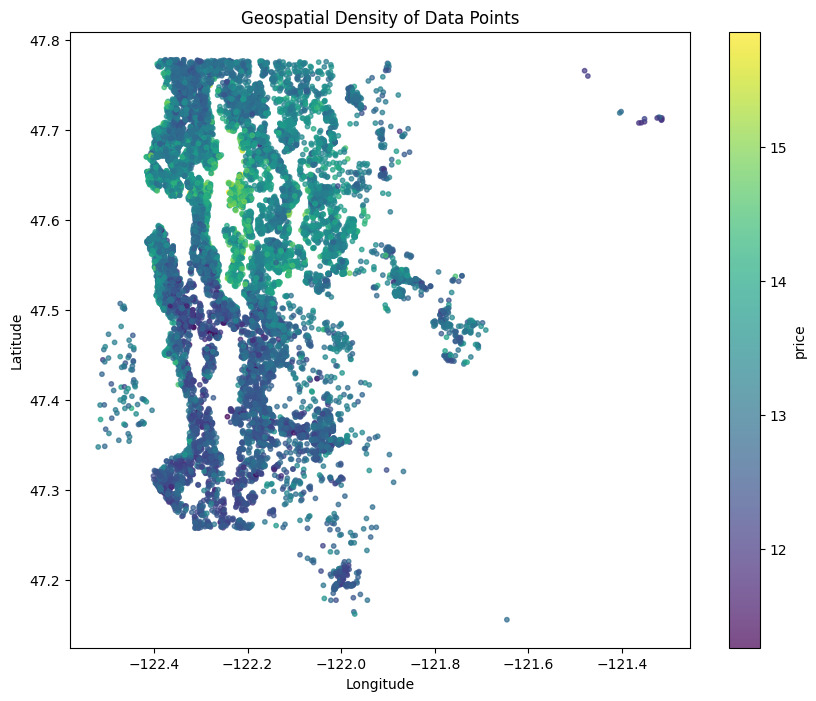

In [77]:
## 밀도에선 insight가 없어서 price를 경위도 격자 위에 뿌려봤다.

plt.figure(figsize=(10, 8))
density_plot = plt.scatter(train['long'], train['lat'], c=train['price'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(density_plot, label='price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Density of Data Points')
plt.show()

In [78]:
# 경위도를 격자 형태로 변환
grid_size = 0.01  # 격자 크기 (적절히 조정 가능)
train['lat_bin'] = (train['lat'] // grid_size) * grid_size
train['long_bin'] = (train['long'] // grid_size) * grid_size

# 각 평균 계산
grid_avg_price = train.groupby(['lat_bin', 'long_bin'])['price'].mean().reset_index()
grid_avg_price.columns = ['lat_bin', 'long_bin', 'avg_price']

# 격자 평균 추가
train = train.merge(grid_avg_price, on=['lat_bin', 'long_bin'], how='left')

# 평균 가격이 높으면, 부촌으로
high_price_threshold = train['avg_price'].quantile(0.91)  # 상위 9%를 부촌으로 간주
train['is_high_price_area'] = (train['avg_price'] >= high_price_threshold).astype(int)

# test 도
test['lat_bin'] = (test['lat'] // grid_size) * grid_size
test['long_bin'] = (test['long'] // grid_size) * grid_size

test = test.merge(grid_avg_price[['lat_bin', 'long_bin', 'avg_price']], on=['lat_bin', 'long_bin'], how='left')
test['is_high_price_area'] = (test['avg_price'] >= high_price_threshold).astype(int)

test['is_high_price_area'].fillna(0, inplace=True)

# 필요없는 변수 drop
train = train.drop(columns=['lat_bin', 'long_bin', 'avg_price'])
test = test.drop(columns=['lat_bin', 'long_bin', 'avg_price'])

# 결과 확인
print(train[['lat', 'long', 'is_high_price_area']].head())
print(test[['lat', 'long', 'is_high_price_area']].head())

       lat     long  is_high_price_area
0  47.5112 -122.257                   0
1  47.7379 -122.233                   0
2  47.6168 -122.045                   0
3  47.3097 -122.327                   0
4  47.4095 -122.315                   0
       lat     long  is_high_price_area
0  47.7210 -122.319                   0
1  47.5208 -122.393                   0
2  47.6561 -122.005                   1
3  47.5123 -122.337                   0
4  47.3684 -122.031                   0


In [79]:
train['is_high_price_area'].value_counts()

,count
is_high_price_area,
0,13670
1,1365


In [80]:
test['is_high_price_area'].value_counts()

,count
is_high_price_area,
0,5880
1,588


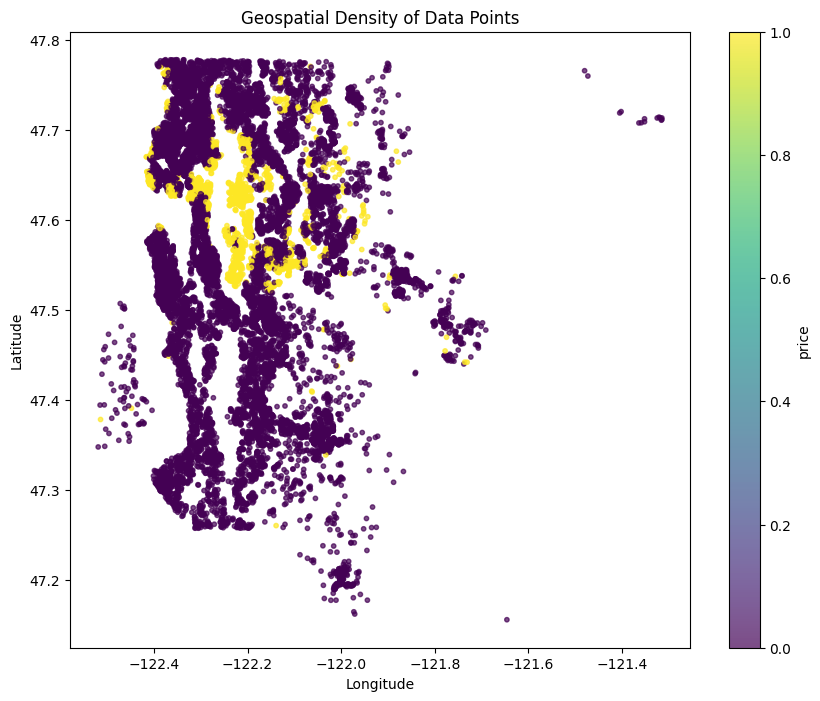

In [81]:
# 굉장히 보수적으로 잡을수록 성능이 좋아진다...
plt.figure(figsize=(10, 8))
density_plot = plt.scatter(train['long'], train['lat'], c=train['is_high_price_area'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(density_plot, label='price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geospatial Density of Data Points')
plt.show()

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                15035 non-null  int64  
 1   price               15035 non-null  float64
 2   bedrooms            15035 non-null  float64
 3   bathrooms           15035 non-null  float64
 4   sqft_living         15035 non-null  float64
 5   sqft_lot            15035 non-null  float64
 6   floors              15035 non-null  float64
 7   waterfront          15035 non-null  int64  
 8   view                15035 non-null  int64  
 9   condition           15035 non-null  int64  
 10  grade               15035 non-null  int64  
 11  sqft_above          15035 non-null  float64
 12  sqft_basement       15035 non-null  float64
 13  yr_built            15035 non-null  int64  
 14  yr_renovated        15035 non-null  int64  
 15  zipcode             15035 non-null  int64  
 16  lat 

In [22]:
train['price'].groupby(train['city']).sum()

,price
city,
Auburn,7540.140031
Bellevue,12990.748215
Black Diamond,811.149344
Bothell,1920.776700
Carnation,1161.135757
Duvall,1693.569376
Enumclaw,2005.526445
Fall City,708.683006
Federal Way,6681.414301


In [23]:
train['price'].groupby(train['city']).mean()

,price
city,
Auburn,12.525150
Bellevue,13.574450
Black Diamond,12.875386
Bothell,13.066508
Carnation,12.901508
Duvall,12.928011
Enumclaw,12.613374
Fall City,13.123759
Federal Way,12.512012


In [24]:
train['city'].value_counts()

,count
city,
Seattle,6269
Renton,1110
Bellevue,957
Kent,858
Redmond,692
Kirkland,678
Auburn,602
Sammamish,553
Federal Way,534


In [86]:
# Sammamish,Mercer Island,Medina,Bellevue 553+193+36 ...
# 이 도시들의 price가 높으니 한 번 추가해보자 (다만, 위 부촌 특정과 어느정도 상관성이 높을 수 있음을 유의하자)
train['high_city'] = train['city'].apply(lambda x: 1 if x in ['Sammamish', 'Mercer Island', 'Medina', 'Bellevue'] else 0)

In [87]:
test['high_city'] = test['city'].apply(lambda x: 1 if x in ['Sammamish', 'Mercer Island', 'Medina', 'Bellevue'] else 0)

In [88]:
test['high_city'].value_counts()

,count
high_city,
0,5684
1,784


In [89]:
train['high_city'].value_counts()

,count
high_city,
0,13296
1,1739


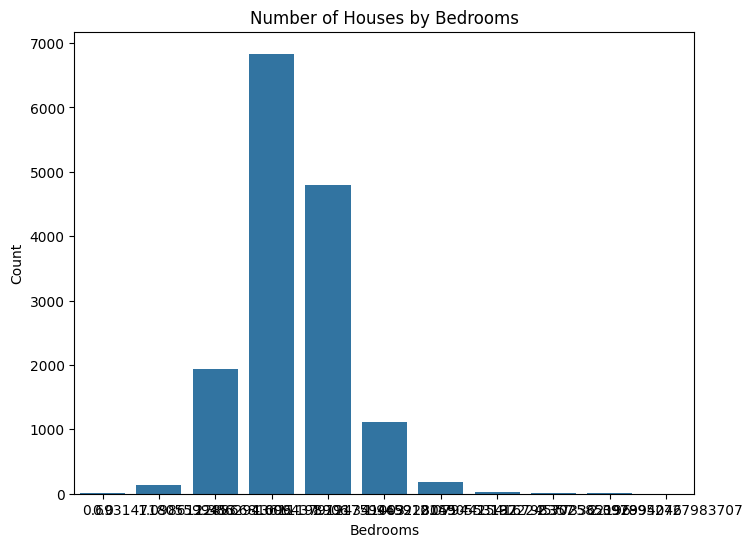

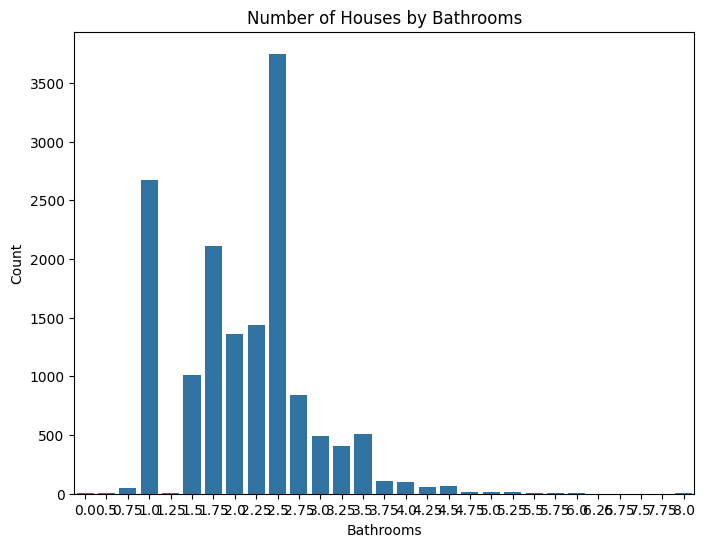

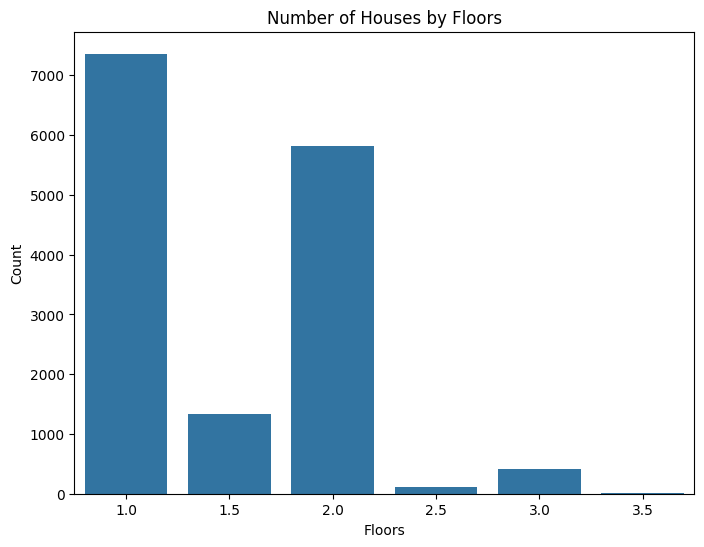

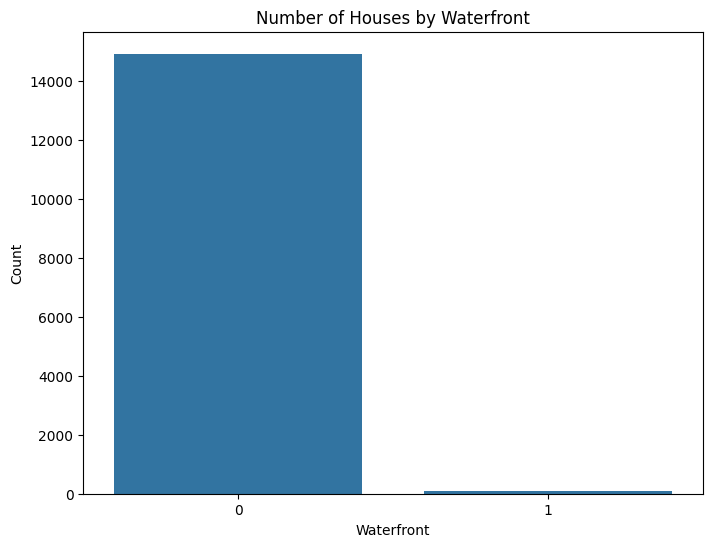

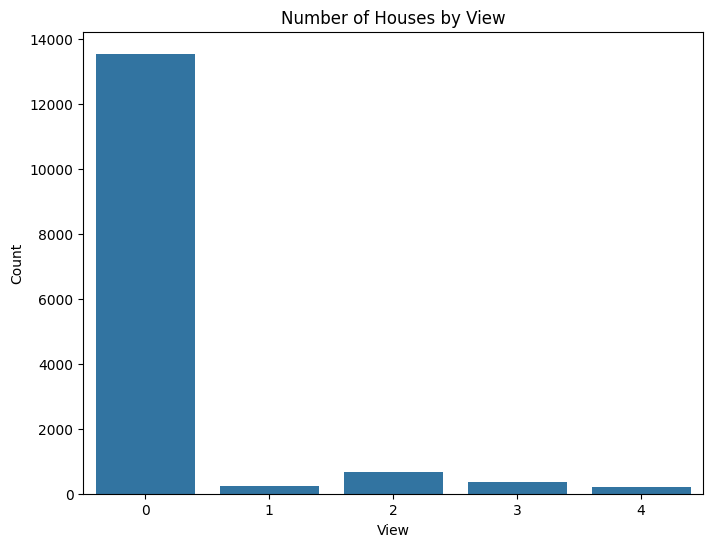

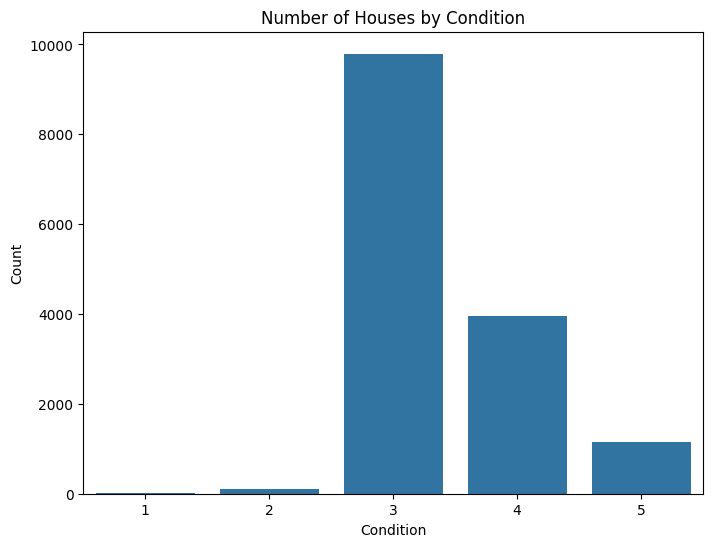

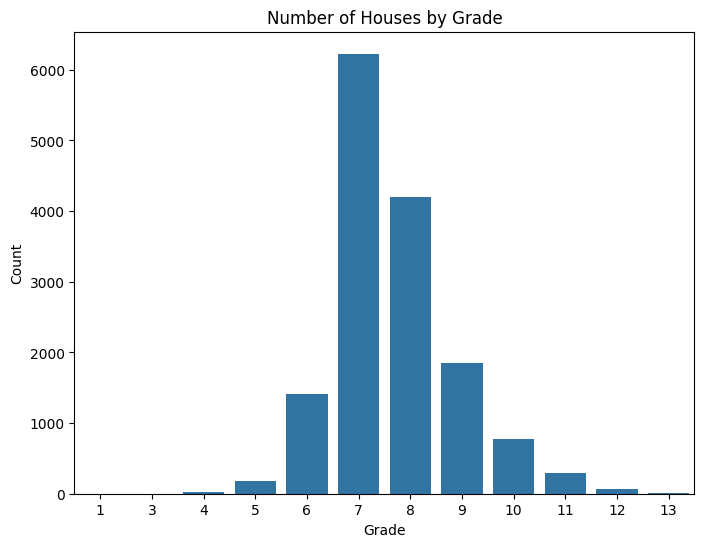

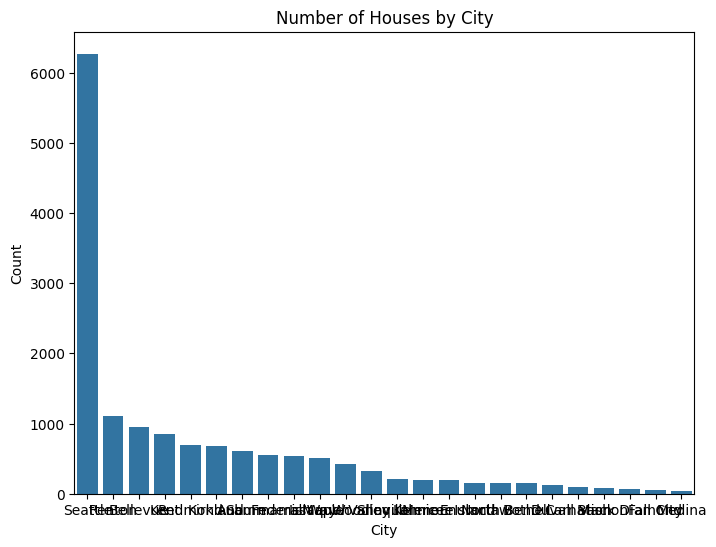

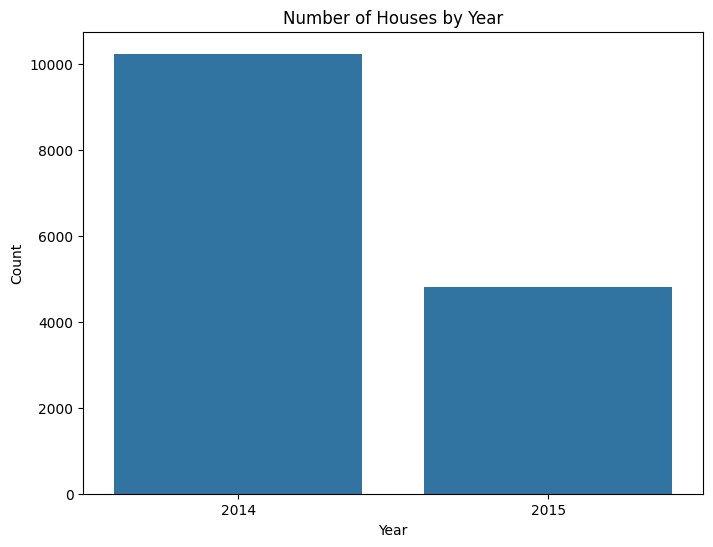

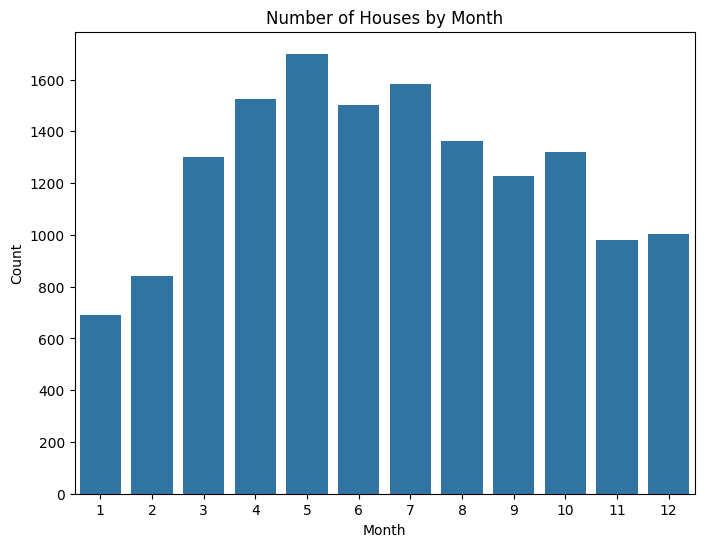

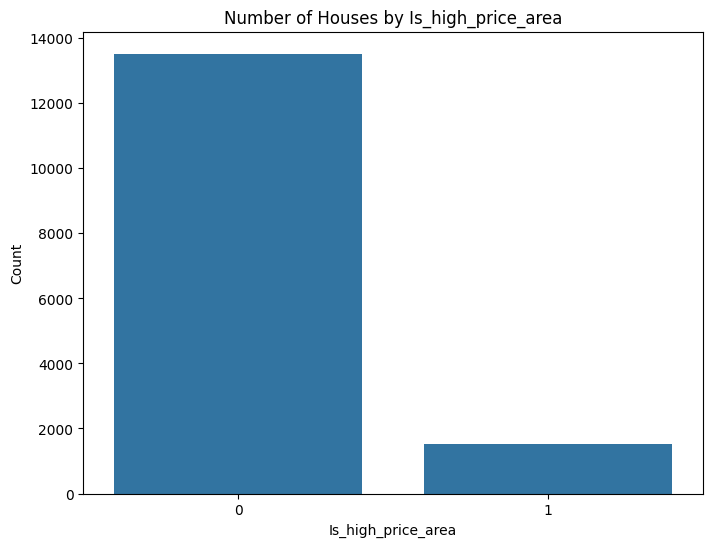

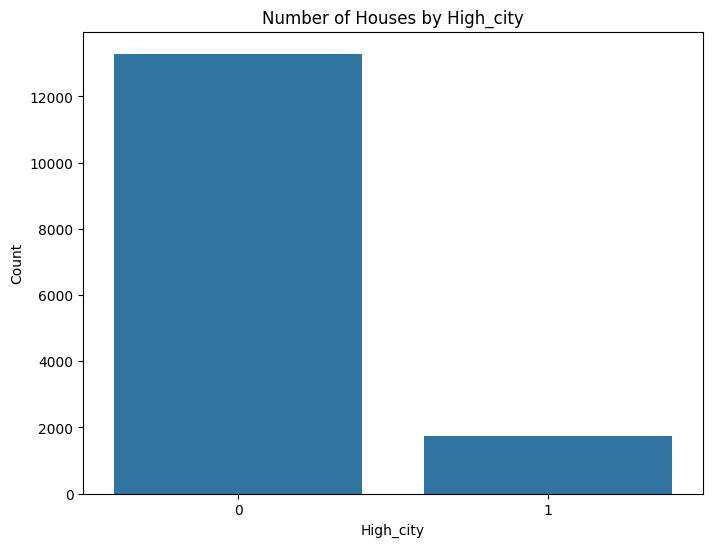

In [28]:
for col in train.columns:
    if train[col].nunique() <= 30:
        plt.figure(figsize=(8, 6))
        sns.barplot(x=train[col].value_counts().index,
                    y=train[col].value_counts().values)
        plt.xlabel(col.capitalize())
        plt.ylabel('Count')
        plt.title(f'Number of Houses by {col.capitalize()}')
        plt.show()

In [ ]:
plt.figure(figsize=(15, 80))

for i, col in enumerate(train.columns, 1):
    plt.subplot(len(train.columns), 1, i)
    sns.scatterplot(x=train[col], y=train['price'])
    plt.title(f'Scatter Plot of {col} vs. price')
    plt.xlabel(col)
    plt.ylabel('pirce')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

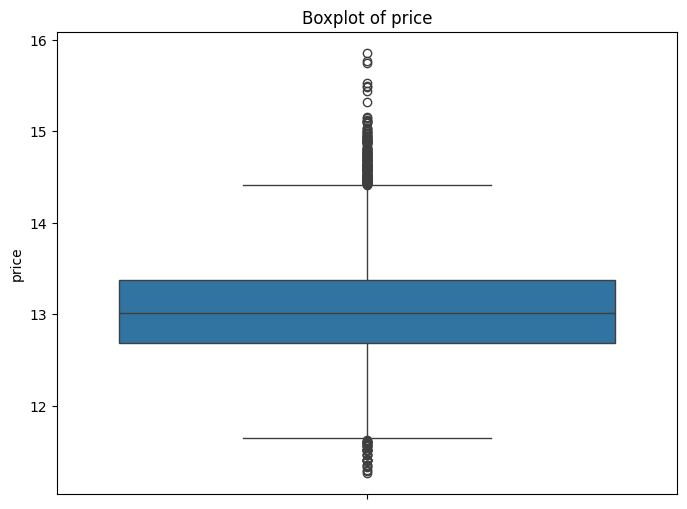

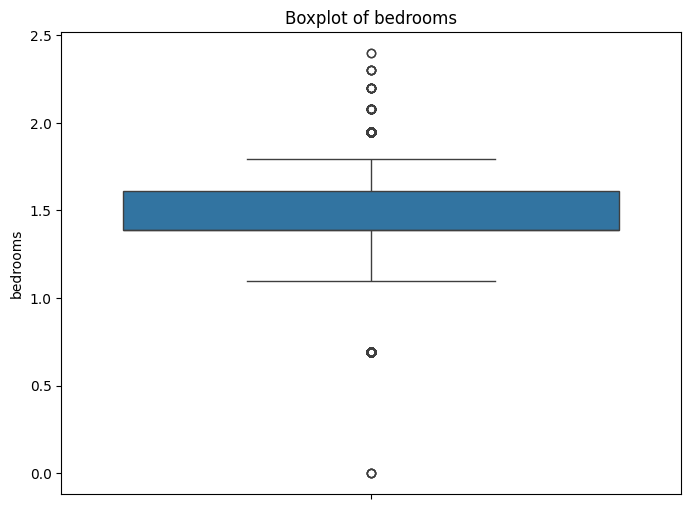

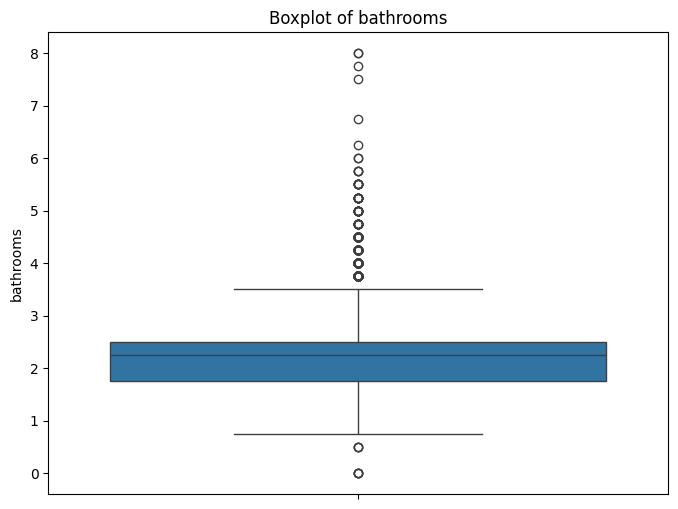

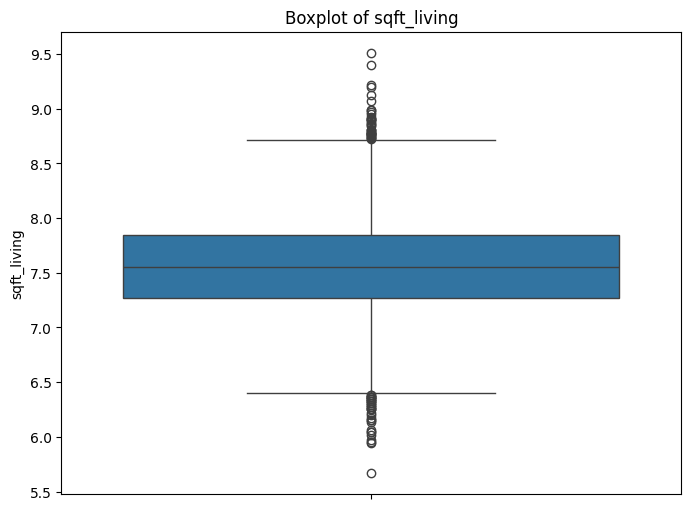

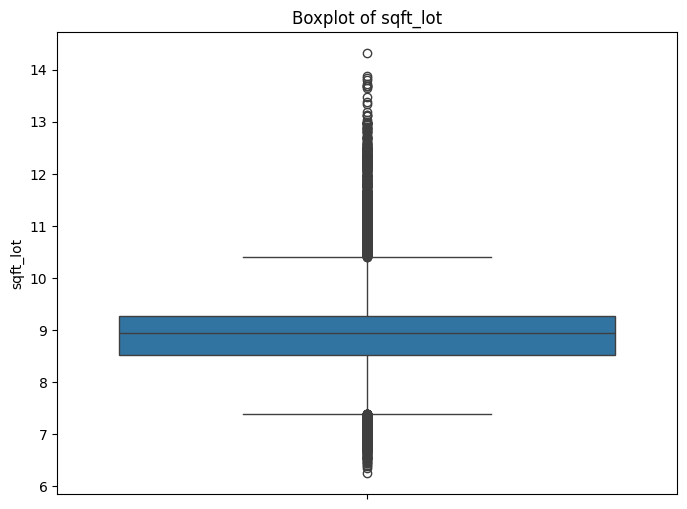

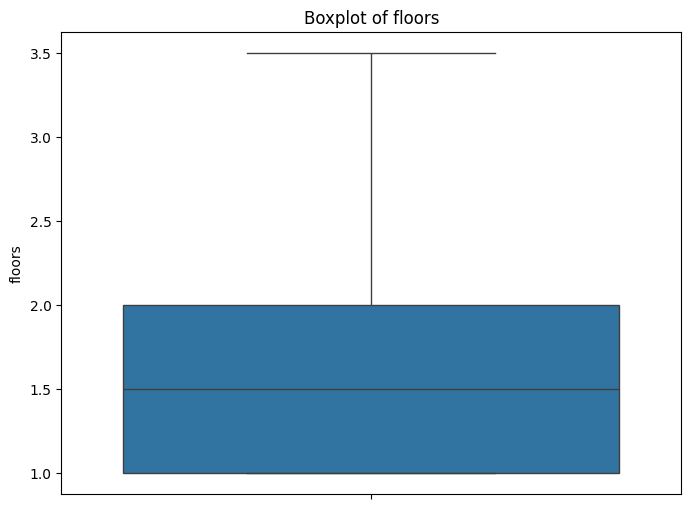

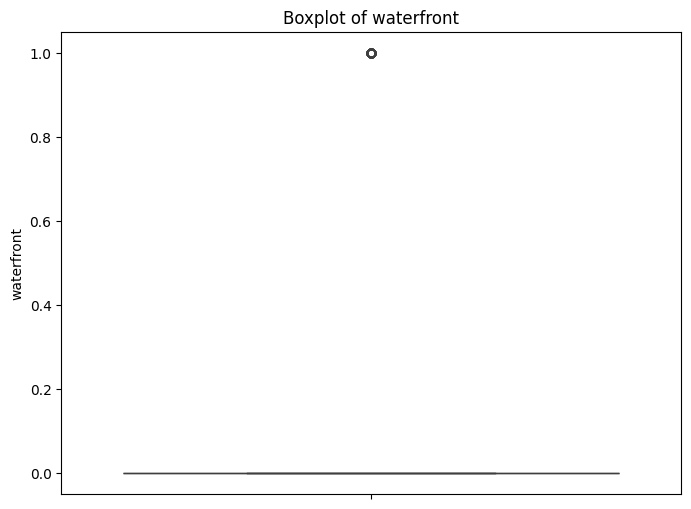

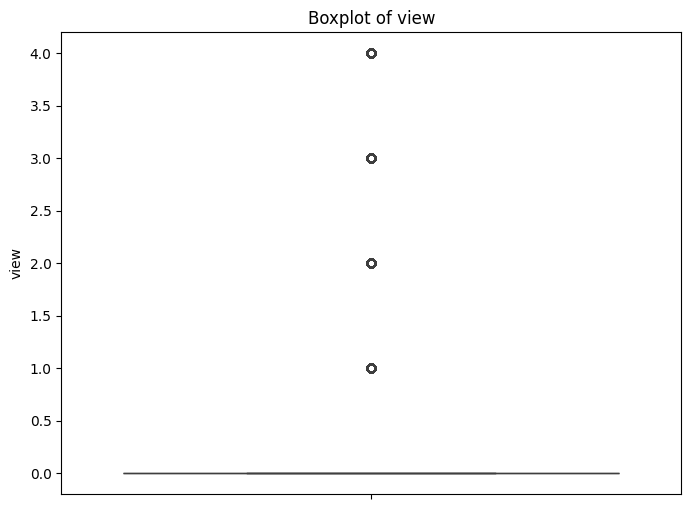

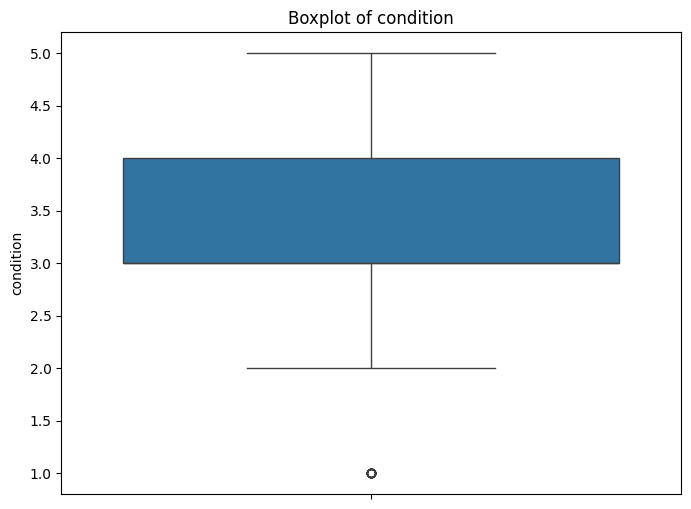

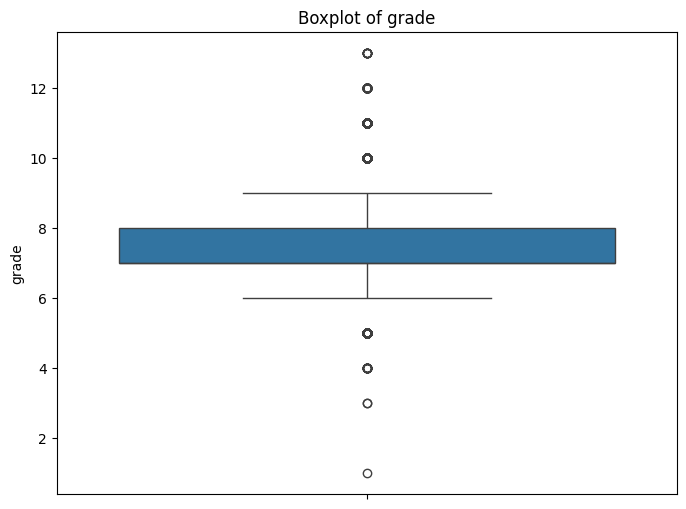

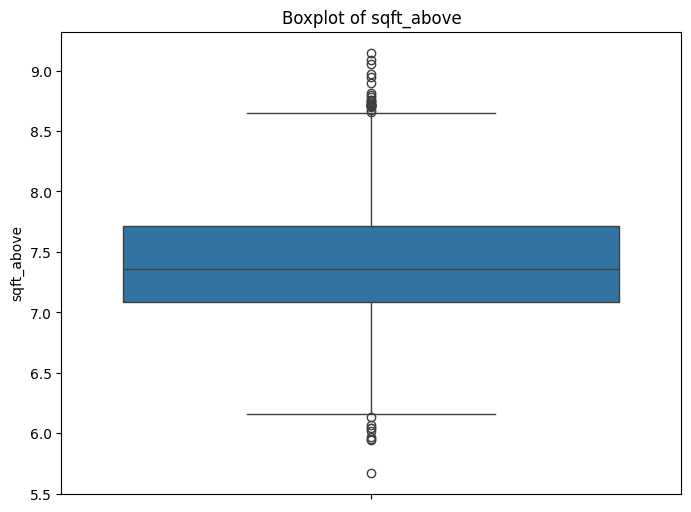

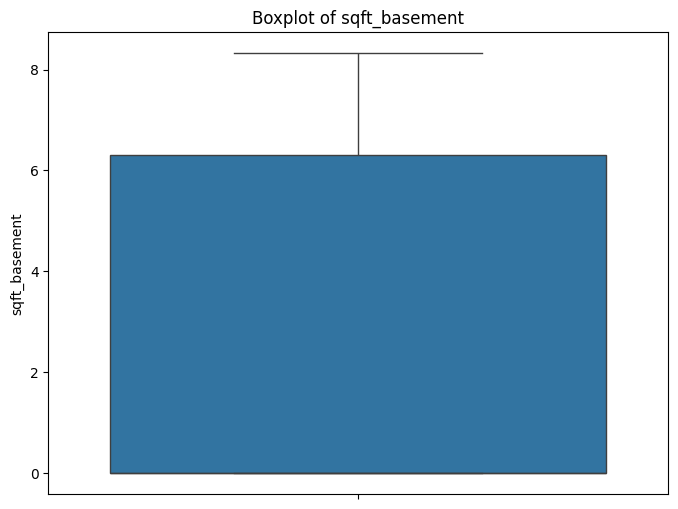

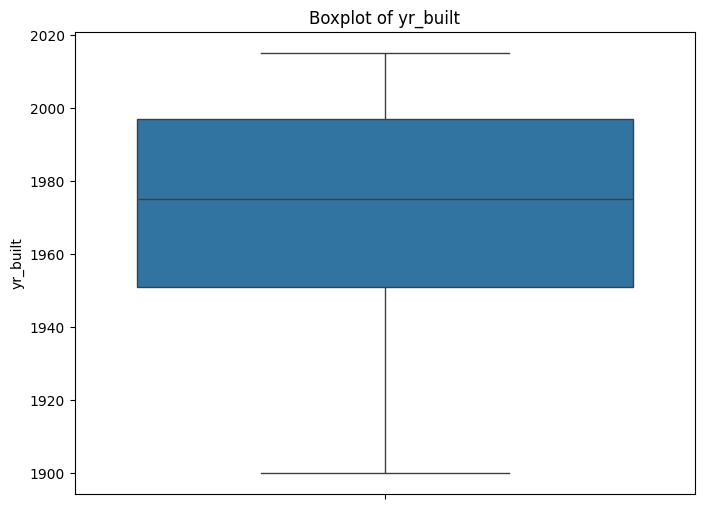

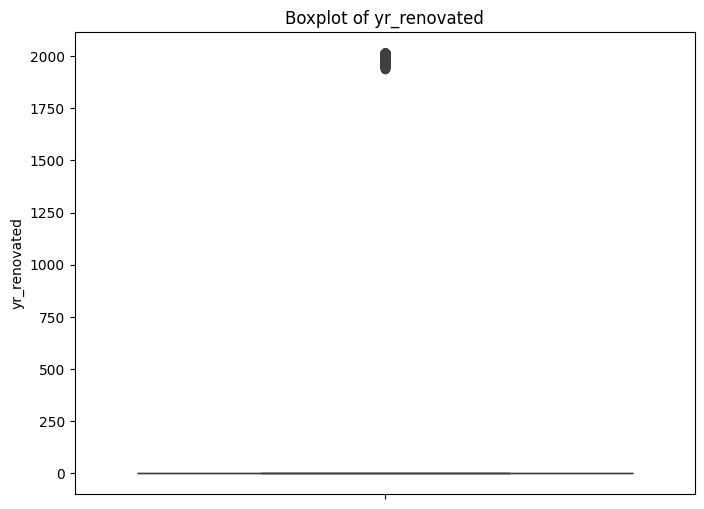

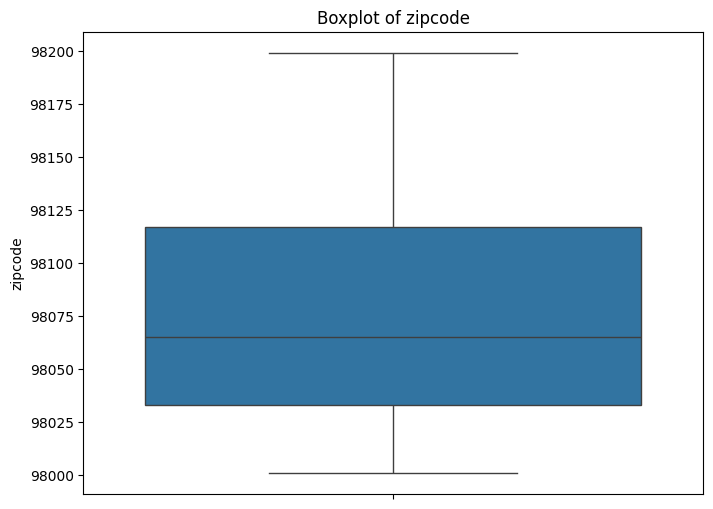

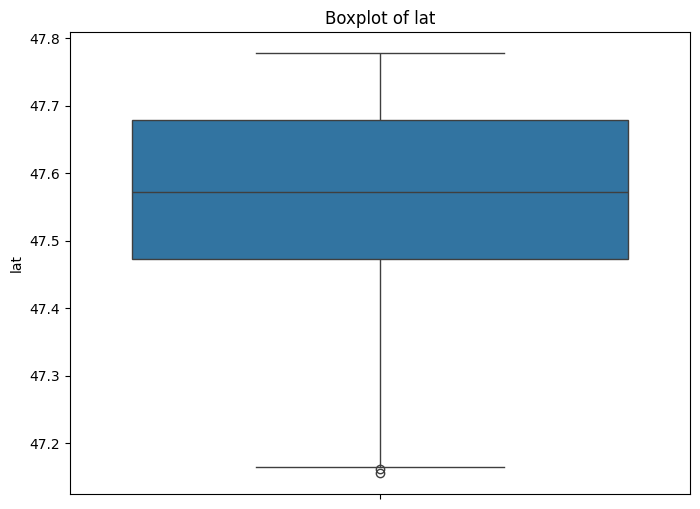

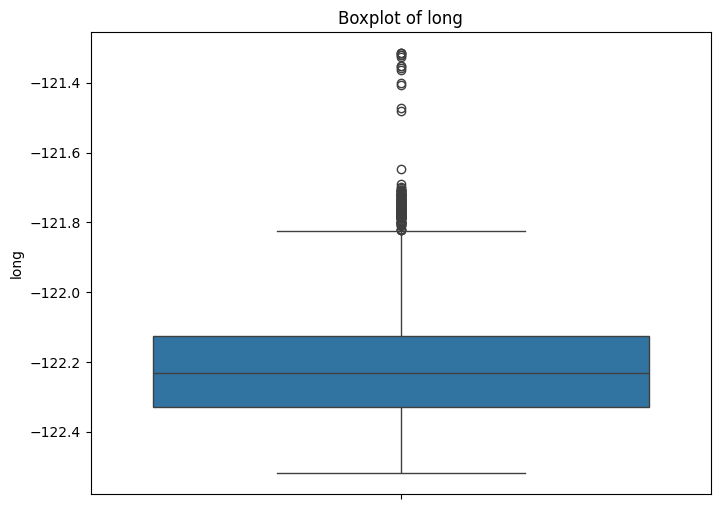

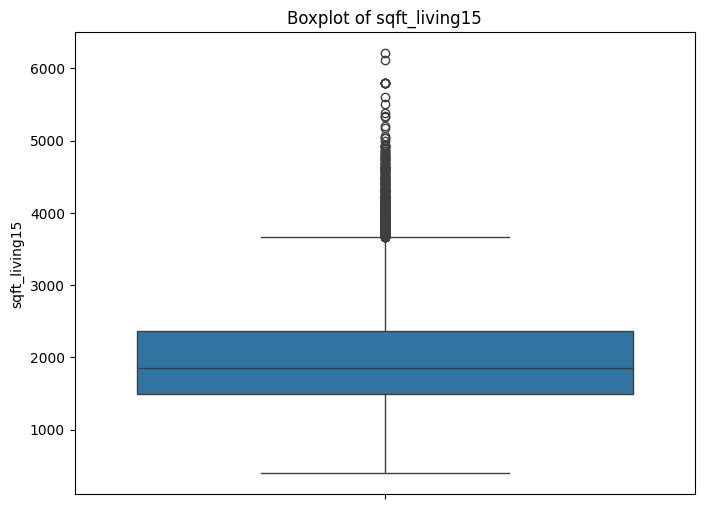

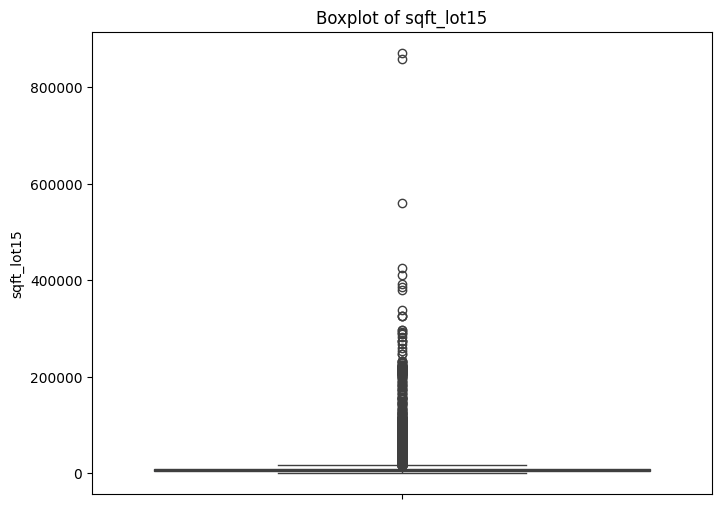

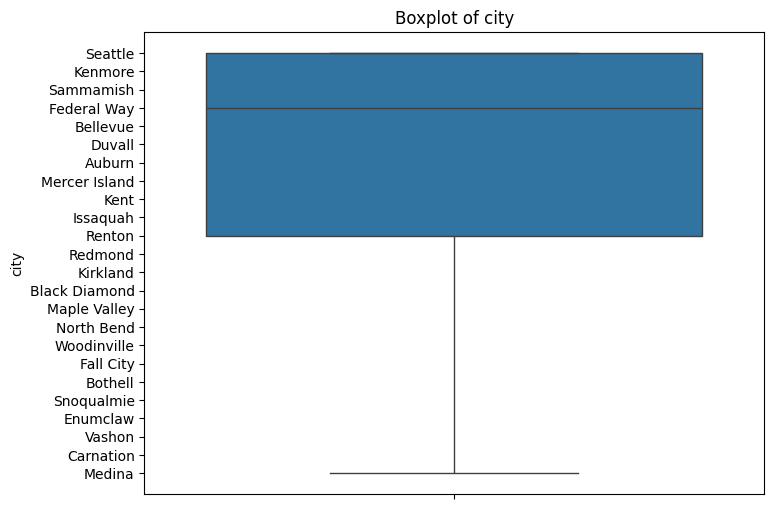

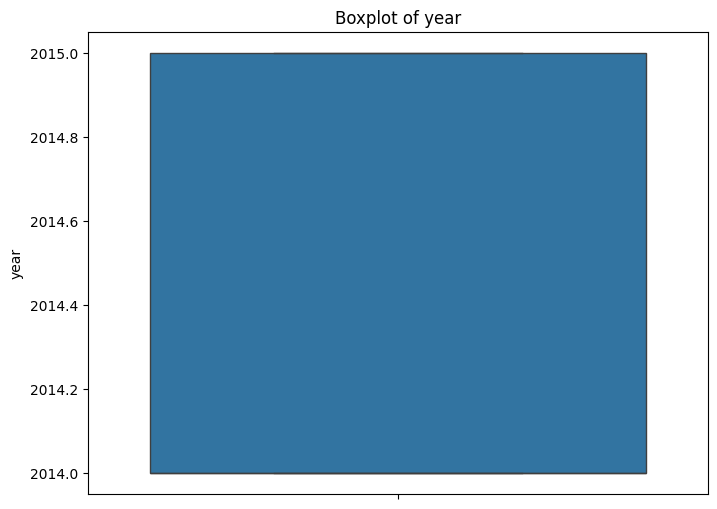

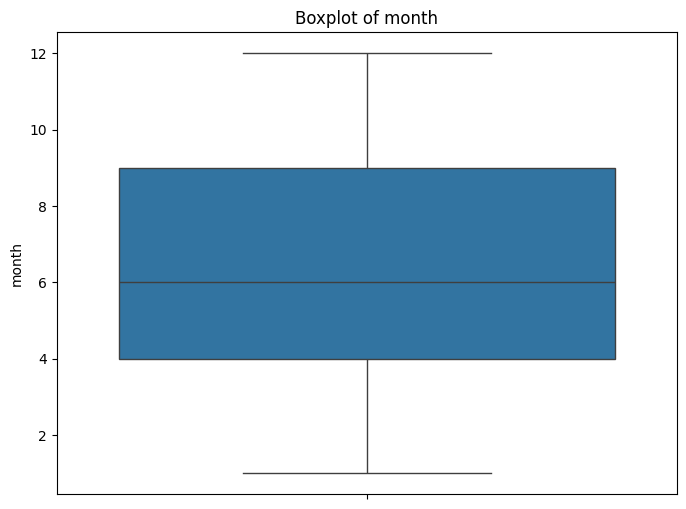

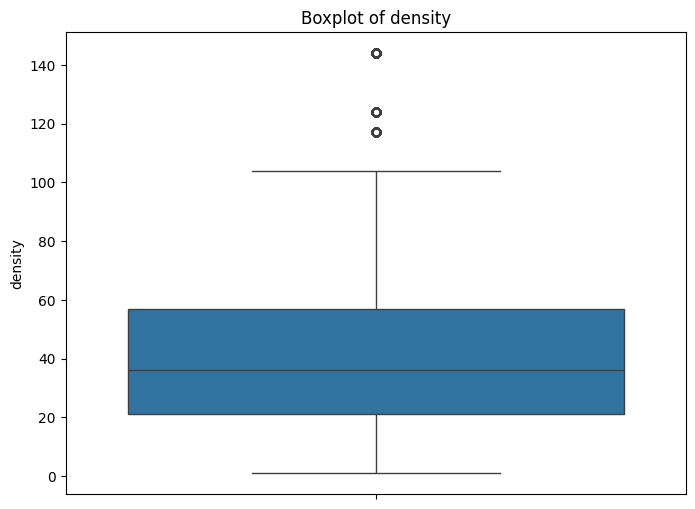

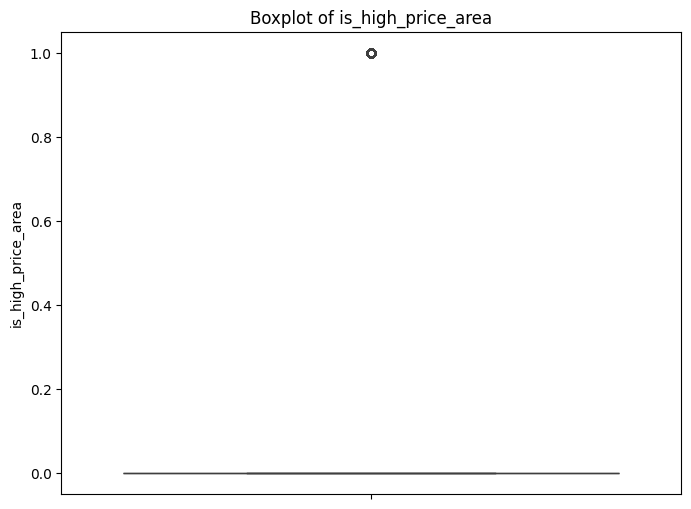

In [ ]:
for col in train.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=train, y=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               15035 non-null  float64
 1   bedrooms            15035 non-null  float64
 2   bathrooms           15035 non-null  float64
 3   sqft_living         15035 non-null  float64
 4   sqft_lot            15035 non-null  float64
 5   floors              15035 non-null  float64
 6   waterfront          15035 non-null  int64  
 7   view                15035 non-null  int64  
 8   condition           15035 non-null  int64  
 9   grade               15035 non-null  int64  
 10  sqft_above          15035 non-null  float64
 11  sqft_basement       15035 non-null  float64
 12  yr_built            15035 non-null  int64  
 13  yr_renovated        15035 non-null  int64  
 14  zipcode             15035 non-null  int64  
 15  lat                 15035 non-null  float64
 16  long

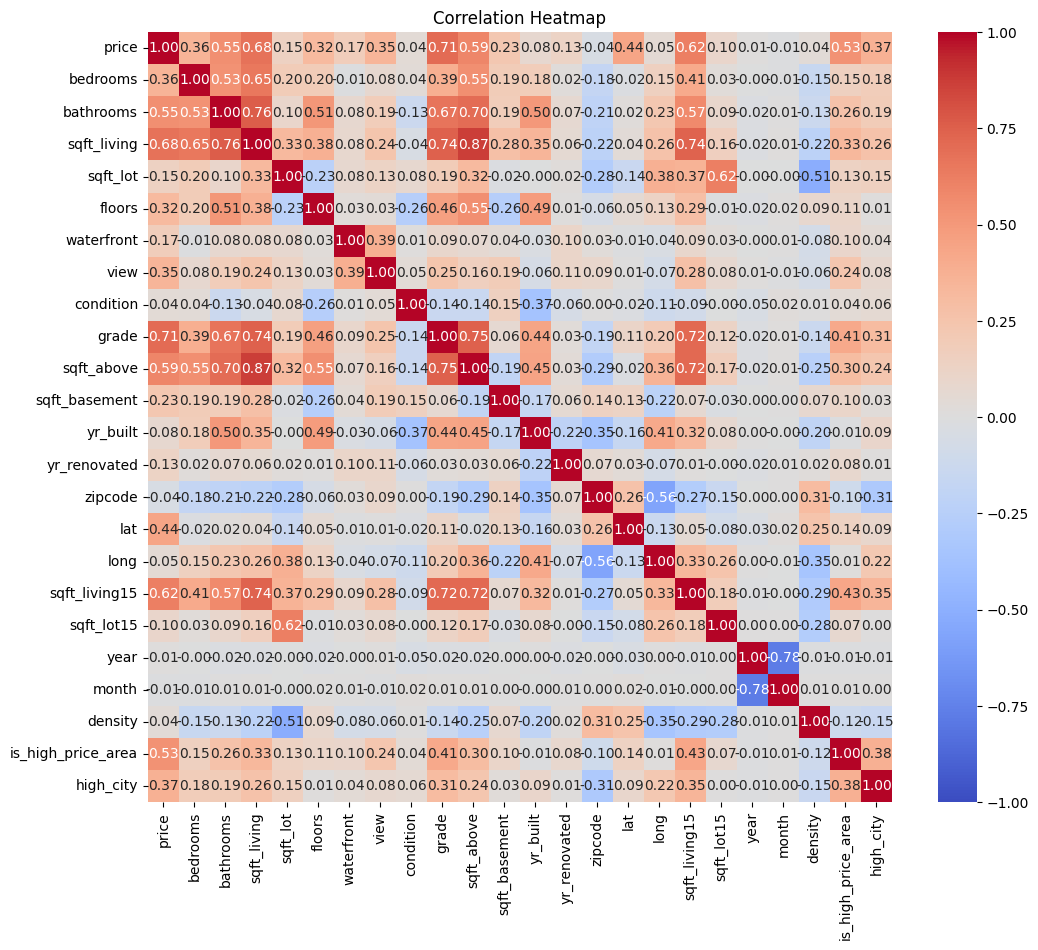

In [30]:
# 상관 행렬
corr_matrix = train.drop(columns=['city']).corr()

# 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [31]:
# 다중공선성 검증
vif_data = pd.DataFrame()
vif_data["feature"] = train.drop(columns=['city']).columns

# 분산팽창
vif_data["VIF"] = [variance_inflation_factor(train.drop(columns=['city']).values, i) for i in range(train.drop(columns=['city']).shape[1])]

print(vif_data)

               feature           VIF
0                price  3.263800e+03
1             bedrooms  9.475088e+01
2            bathrooms  2.886620e+01
3          sqft_living  8.687962e+03
4             sqft_lot  3.116667e+02
5               floors  2.252291e+01
6           waterfront  1.227231e+00
7                 view  1.573441e+00
8            condition  3.702443e+01
9                grade  1.698444e+02
10          sqft_above  7.971567e+03
11       sqft_basement  1.082557e+01
12            yr_built  1.185741e+04
13        yr_renovated  1.206688e+00
14             zipcode  5.582086e+06
15                 lat  2.119174e+05
16                long  1.443641e+06
17       sqft_living15  2.922789e+01
18          sqft_lot15  2.225016e+00
19                year  4.695676e+06
20               month  6.383927e+00
21             density  5.061047e+00
22  is_high_price_area  1.806027e+00
23           high_city  1.621327e+00


In [ ]:
# one_hot_columns = ['is_high_price_area','floors','city']
# train = pd.get_dummies(train, columns=one_hot_columns)
# test = pd.get_dummies(test, columns=one_hot_columns)

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                15035 non-null  int64  
 1   price               15035 non-null  float64
 2   bedrooms            15035 non-null  float64
 3   bathrooms           15035 non-null  float64
 4   sqft_living         15035 non-null  float64
 5   sqft_lot            15035 non-null  float64
 6   floors              15035 non-null  float64
 7   waterfront          15035 non-null  int64  
 8   view                15035 non-null  int64  
 9   condition           15035 non-null  int64  
 10  grade               15035 non-null  int64  
 11  sqft_above          15035 non-null  float64
 12  sqft_basement       15035 non-null  float64
 13  yr_built            15035 non-null  int64  
 14  yr_renovated        15035 non-null  int64  
 15  zipcode             15035 non-null  int64  
 16  lat 

In [33]:
# train = train.drop(columns=['density','month','year','lat','long','sqft_lot15','zipcode','yr_built','yr_renovated','sqft_lot','sqft_living'])
# test = test.drop(columns=['density','month','year','lat','long','sqft_lot15','zipcode','yr_built','yr_renovated','sqft_lot','sqft_living'])

In [91]:
# 내 생각에는 zipcode나 경위도, 재개발 등 의미없어 보이는 변수조차도 국소적인 부분에 중복적으로 머무르는 test의 특성 상 머신러닝에서 효율을 보이는 것 같다.
# 이상치, 변수 drop 등이 큰 의미를 보이지 않는 이유. 따라서, 아래 3개만 삭제했다.

train = train.drop(columns=['density','date','city'])
test = test.drop(columns=['density','date','city'])

In [92]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
# x_train = train.drop(columns=['price'])
# y_train = train['price']
# x_test = test
# # train 데이터를 학습용과 검증용으로
# random_state=2020
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=random_state)

# 처음엔 검증을 사용하여 rmse를 비교했고 가장 좋은 모델(lightgbm)을 특정한 후, k-fold 사용을 위해 val 삭제

In [93]:
x_train = train.drop(columns=['price'])
y_train = train['price']
x_test = test

In [94]:
x_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'is_high_price_area', 'high_city'],
      dtype='object')

In [95]:
x_test.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'is_high_price_area', 'high_city'],
      dtype='object')

In [96]:
x_train.shape,y_train.shape,x_test.shape

((15035, 20), (15035,), (6468, 20))

* 스태킹은 안타깝게도 ligntgbm의 성능이 압도적으로 좋아서 부가적인 모델을 넣어봐야 성능만 떨어지게 된다.
* 다만, lightgbm의 하이퍼파라미터를 아주 깊게 조정하고 특성 상 속도가 빠르므로 k-fold 역시 횟수를 크게 늘린 다음,
* 과적합을 방지하기 위해 스태킹에서final estimator로 Ridge를 사용하였다.
* 또한, 스태킹에도 k-fold를 사용하여 과적합을 줄이고 모델의 일반화 성능을 높이기로 했다.

In [99]:
from sklearn.linear_model import Ridge
# LightGBM 모델 초기화
lightgbm = LGBMRegressor(random_state=2020)

# 하이퍼파라미터 그리드 정의 (LightGBM만 사용)
param_grid = {
    'n_estimators': [250,300,350,360],
    'max_depth': [10,15,30,40]
}

# LightGBM 모델의 최적 하이퍼파라미터 찾기 (K-Fold 적용)
print("Starting GridSearchCV for LightGBM...")
grid_search = GridSearchCV(lightgbm, param_grid, cv=15, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)
best_lightgbm = grid_search.best_estimator_
print(f"Best params for LightGBM: {grid_search.best_params_}")
print(f"Best RMSE for LightGBM: {np.sqrt(-grid_search.best_score_):.4f}")


stack_reg = StackingRegressor(
    estimators=[('lightgbm', best_lightgbm)],
    final_estimator=Ridge(),
    n_jobs=-1
)

# 스태킹 모델의 K-Fold 교차 검증 (전체 성능 평가용)
kf = KFold(n_splits=15, shuffle=True, random_state=2020)
stack_rmse_scores = cross_val_score(stack_reg, x_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
stack_rmse_scores = np.sqrt(-stack_rmse_scores)

print(f"Cross-validated RMSE scores for Stacked Model (LightGBM + Ridge): {stack_rmse_scores}")
print(f"Mean RMSE: {stack_rmse_scores.mean():.4f}")
print(f"Standard Deviation of RMSE: {stack_rmse_scores.std():.4f}")

# 전체 데이터로 최종 스태킹 모델 학습
stack_reg.fit(x_train, y_train)

# 최종 테스트 데이터에 대한 예측 및 변환
final_pred = stack_reg.predict(x_test)
final_pred = np.expm1(final_pred)  # 필요 시 역변환

Starting GridSearchCV for LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2328
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 20
[LightGBM] [Info] Start training from score 13.048122
Best params for LightGBM: {'max_depth': 30, 'n_estimators': 350}
Best RMSE for LightGBM: 0.1615
Cross-validated RMSE scores for Stacked Model (LightGBM + Ridge): [0.16959478 0.15715274 0.15893366 0.16218845 0.16166075 0.16751133
 0.15818636 0.15872046 0.16814373 0.15960209 0.1606956  0.16951537
 0.15972574 0.15124342 0.16152252]
Mean RMSE: 0.1616
Standard Deviation of RMSE: 0.0049


* 19번은 과적합
* 20번은 ridge로 일반화를 시킨 모델이다.

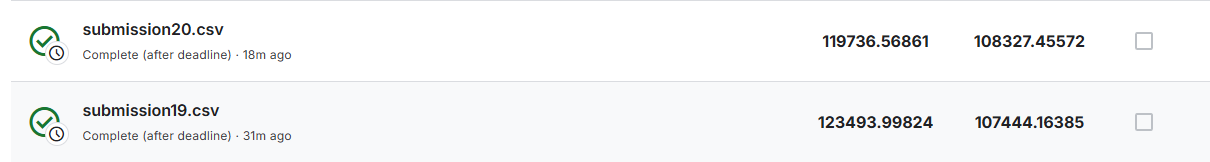

In [101]:
from IPython.display import Image, display

# 이미지 경로 설정
img_path = '/content/drive/MyDrive/aiffel/Data/결과.png'

# 이미지 출력
display(Image(filename=img_path))

In [ ]:
# # 모델 초기화
# gboost = GradientBoostingRegressor(random_state=2020)
# lightgbm = LGBMRegressor(random_state=2020)
# rdforest = RandomForestRegressor(random_state=2020)
# xgboost = XGBRegressor(random_state=2020)

# # 하이퍼파라미터 그리드 정의
# param_grids = {
#     'gboost': {
#         'n_estimators': [150, 200, 250],
#         'max_depth': [10, 30, 50]
#     },
#     'lightgbm': {
#         'n_estimators': [150, 200, 250],
#         'max_depth': [10, 30, 50]
#     },
#     'rdforest': {
#         'n_estimators': [150, 200, 250],
#         'max_depth': [10, 30, 50]
#     }
# }

In [ ]:
# # 개별 모델의 최적 하이퍼파라미터 찾기 (K-Fold 적용)
# best_models = {}
# for name, model in zip(['gboost', 'lightgbm', 'rdforest'], [gboost, lightgbm, rdforest]):
#     print(f"Starting GridSearchCV for {name}...")
#     grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#     grid_search.fit(x_train, y_train)
#     best_models[name] = grid_search.best_estimator_
#     print(f"Best params for {name}: {grid_search.best_params_}")
#     print(f"Best RMSE for {name}: {np.sqrt(-grid_search.best_score_):.4f}")

# # 최적의 모델로 스태킹
# stack_models = [
#     ('gboost', best_models['gboost']),
#     ('lightgbm', best_models['lightgbm']),
#     ('rdforest', best_models['rdforest'])
# ]

# # 스태킹 모델 정의 (xgboost를 최종 예측기로 사용)
# stack_reg = StackingRegressor(estimators=stack_models, final_estimator=xgboost, n_jobs=-1)

# # 스태킹 모델의 K-Fold 교차 검증 (전체 성능 평가용)
# kf = KFold(n_splits=5, shuffle=True, random_state=2020)
# stack_rmse_scores = cross_val_score(stack_reg, x_train, y_train, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
# stack_rmse_scores = np.sqrt(-stack_rmse_scores)

# print(f"Cross-validated RMSE scores for Stacked Model: {stack_rmse_scores}")
# print(f"Mean RMSE: {stack_rmse_scores.mean():.4f}")
# print(f"Standard Deviation of RMSE: {stack_rmse_scores.std():.4f}")

# # 전체 데이터로 최종 스태킹 모델 학습
# stack_reg.fit(x_train, y_train)

# # 검증 데이터에 대한 예측 및 RMSE 확인
# stack_pred = stack_reg.predict(x_val)
# stack_rmse = rmse(y_val, stack_pred)
# print(f"Stacked Model RMSE on Validation Set: {stack_rmse:.4f}")

# # 최종 테스트 데이터에 대한 예측 및 변환
# final_pred = stack_reg.predict(x_test)
# final_pred = np.expm1(final_pred)  # 필요 시 역변환

Starting GridSearchCV for gboost...
Best params for gboost: {'max_depth': 10, 'n_estimators': 150}
Best RMSE for gboost: 0.1776
Starting GridSearchCV for lightgbm...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2334
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 43
[LightGBM] [Info] Start training from score 13.047779
Best params for lightgbm: {'max_depth': 30, 'n_estimators': 250}
Best RMSE for lightgbm: 0.1649
Starting GridSearchCV for rdforest...
Best params for rdforest: {'max_depth': 50, 'n_estimators': 250}
Best RMSE for rdforest: 0.1790
Cross-validated RMSE scores for Stacked Model: [0.17340106 0.17337478 0.17163404 0.1792787  0.17747235]
Mean RMSE: 0.